In [184]:
import sys
sys.path.append("../../XLEMOO")

In [303]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier
import imodels

## Define problem

In [304]:
n_objectives = 5
n_variables = 2

# problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
problem = river_pollution_problem()

## Setting model parameters

In [331]:
# nadir = np.ones(n_objectives)
# ideal = np.zeros(n_objectives)
ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
#ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
#guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

lower_limits = np.array([-5.5, -3.2, -5.4, 3.2, 0.05])
upper_limits = np.array([-3.9, -2.9, -0.9, 7.2, 0.20])

#lower_limits = np.array([0.3, 0.4, 0.5])
#upper_limits = np.array([0.4, 0.5, 0.6])
ref_point = (lower_limits + upper_limits) / 2

inside_ranges_fun = inside_ranges(lower_limits, upper_limits, sim_cost=0.8)
stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ref_point})
guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})


fitness_fun = lambda x: inside_ranges_fun(x)

# fitness_fun = naive_sum
# fitness_fun = hypervolume_contribution(nadir)

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=10
)

ea_params = EAParams(
    population_size=50,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=3),
    selection_op=SelectNBest(None, 50),
    population_init_design="LHSDesign",
    iterations_per_cycle=10,
)

# ml = DecisionTreeClassifier(random_state=0, max_depth=5)
ml = SlipperClassifier()
# ml = BoostedRulesClassifier()
ml_params = MLParams(
    H_split=0.05,
    L_split=0.9,
    ml_model=ml,
    instantation_factor=1.0,
    generation_lookback=3,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [332]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [333]:
lemoo.run_iterations()

.
.
.
.
.
.
.
.
.
.


{'darwin_mode': 100, 'learning_mode': 10, 'total_iterations': 10}

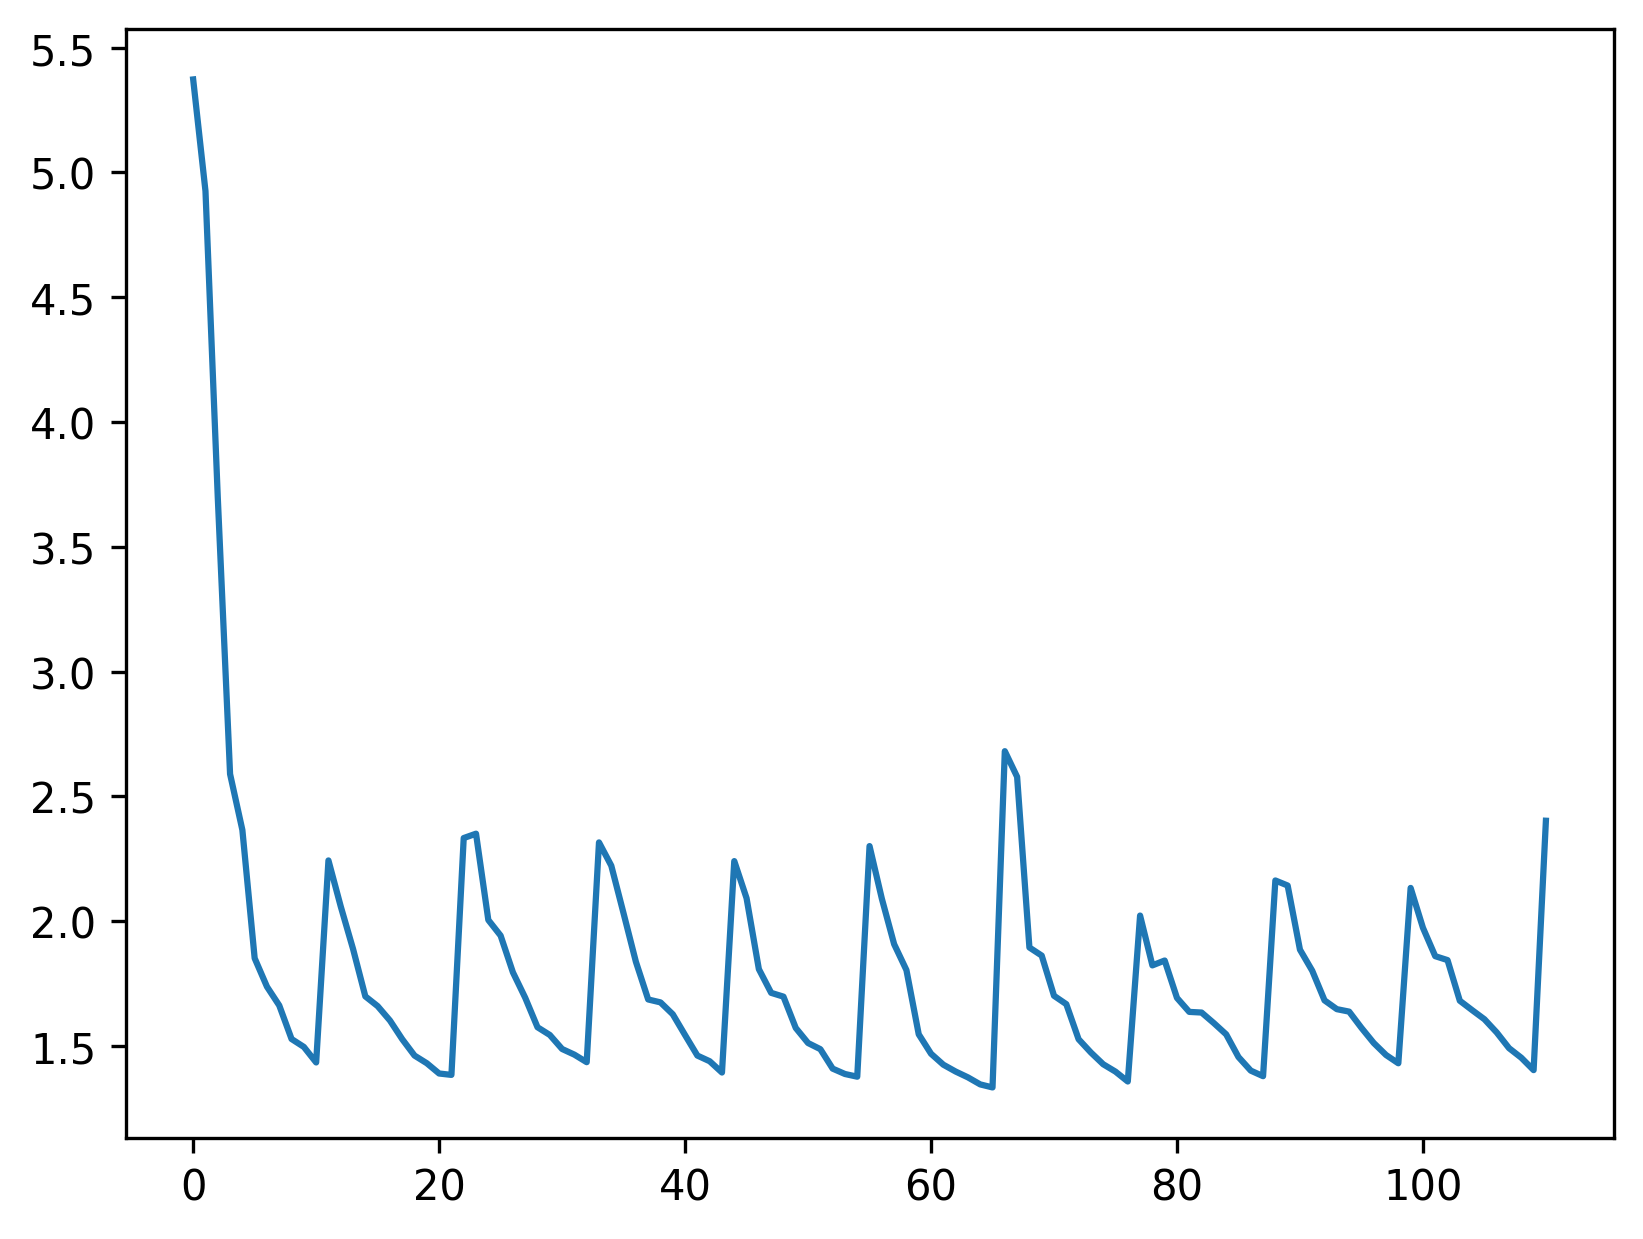

In [334]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

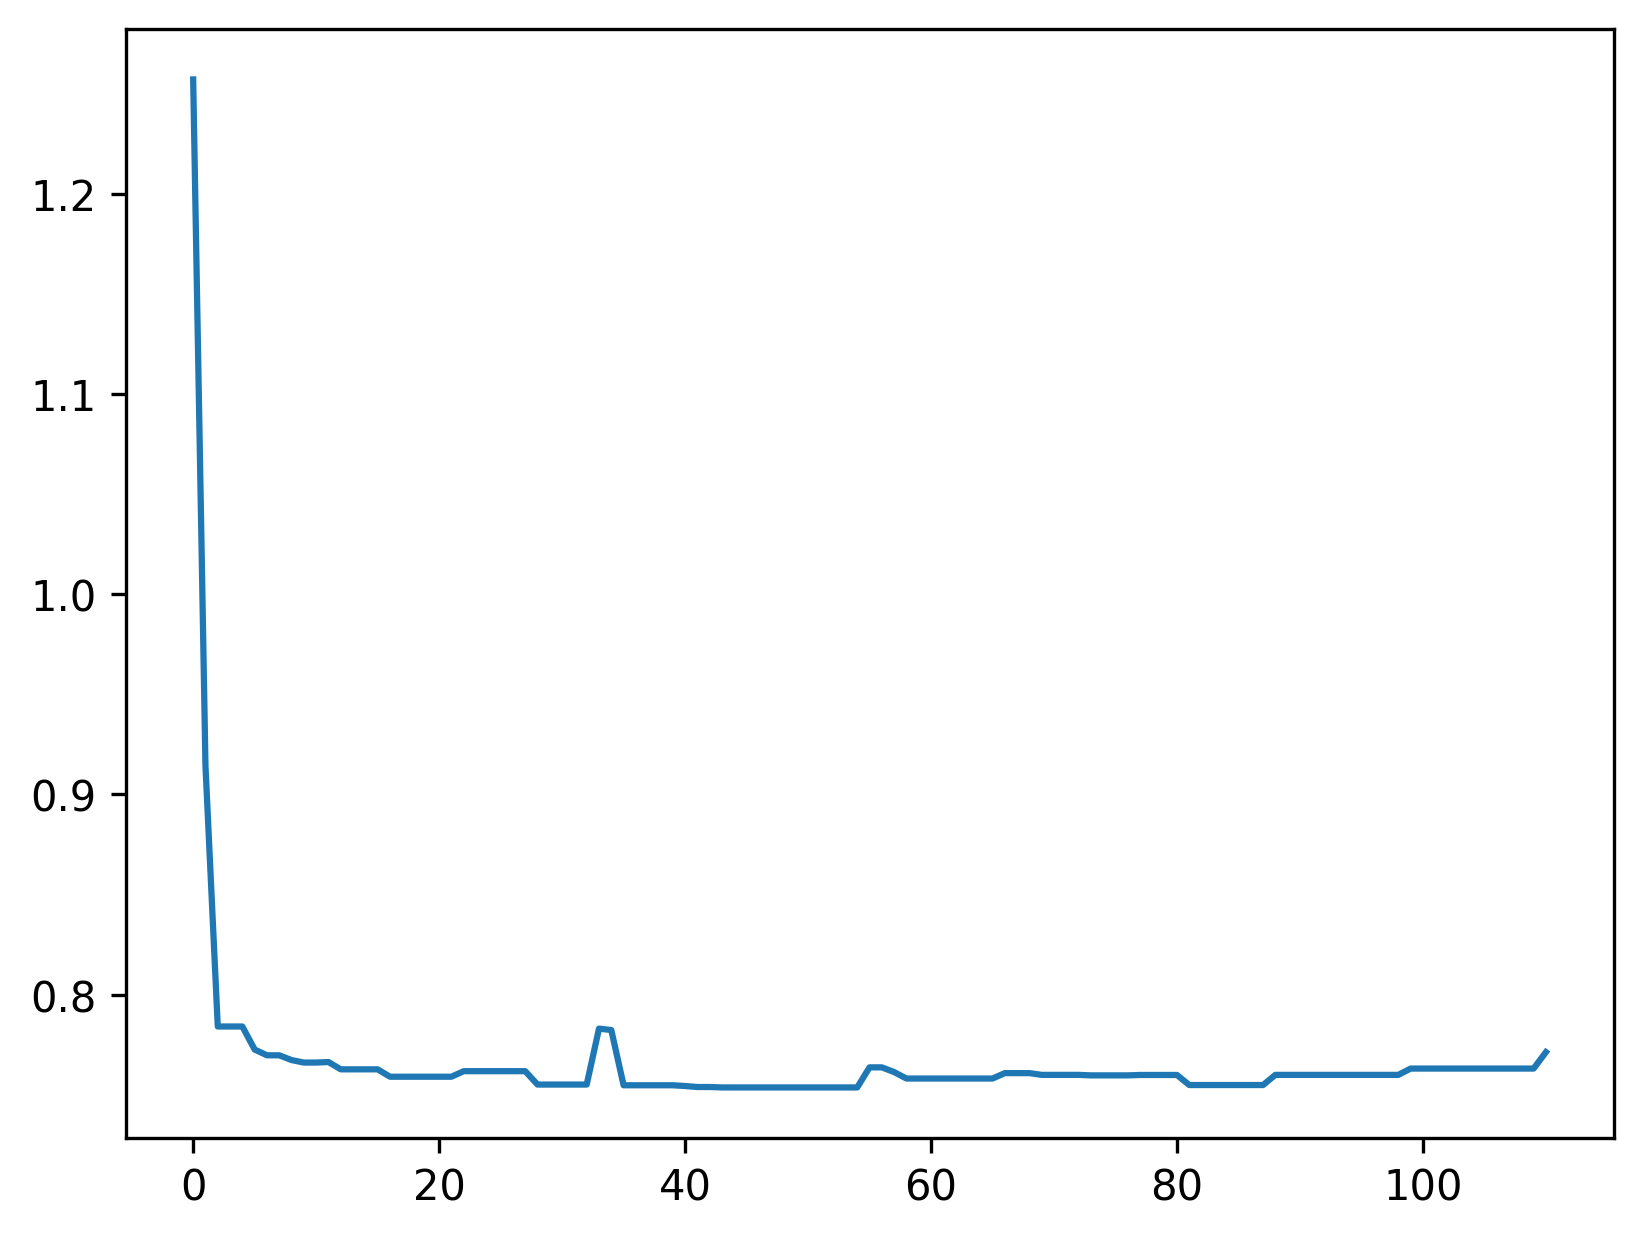

In [336]:
plot_best_fitnesses(lemoo._generation_history)

In [337]:
print(lemoo.current_ml_model)
# tree.plot_tree(lemoo.current_ml_model)

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If X_1 < 0.9381176968476508 and X_2 < 0.9432733363376292 and X_2 > 0.9247363044677019 → 0.98 (weight: -1.29)
  If X_1 == 0.9192143631918919 → 0.02 (weight: 0.69)
  If X_1 == 0.9188346791339992 → 0.02 (weight: 0.64)
  If X_1 == 0.9188346791339992 → 0.02 (weight: 0.00)
  If X_1 == 0.9192143631918919 → 0.02 (weight: -0.05)
  If X_1 < 0.9193386885977378 and X_2 < 0.9297985318555868 and X_2 > 0.9275530787365862 → 0.02 (weight: -0.00)
  If X_2 == 0.9283380667308954 → 0.02 (weight: -0.00)
  If X_1 < 0.9381176968476508 and X_1 > 0.9119607343978534 and X_2 < 0.9432733363376292 and X_2 > 0.9247363044677019 → 0.97 (weight: 0.66)
  If X_1 < 0.9381176968476508 and X_1 > 0.9119607343978534 and X_2 < 0.9432733363376292 and X_2 > 0.9247363044677019 → 0.97 (weight: -0.00)
  If X_2 == 0.9283380667308954 → 0.02 (weight: 0.39)



In [328]:
problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives

array([[-6.14934132, -3.23116561, -5.38048946,  3.22991432,  0.27783531]])

In [329]:
lemoo._generation_history[-1].individuals

array([[0.91600939, 0.92783531],
       [0.91735769, 0.92820535],
       [0.91736253, 0.92820883],
       [0.92000444, 0.9337578 ],
       [0.93190847, 0.92837143],
       [0.9226292 , 0.9376743 ],
       [0.93749822, 0.92967546],
       [0.91959237, 0.94954261],
       [0.91162662, 0.93749937],
       [0.9328633 , 0.95258759],
       [0.91759   , 0.9633411 ],
       [0.95739135, 0.93017757],
       [0.94584776, 0.95055534],
       [0.94581455, 0.95065642],
       [0.95197481, 0.94853201],
       [0.95429461, 0.95281761],
       [0.90913061, 0.95440135],
       [0.91699432, 0.98098256],
       [0.91698884, 0.98281966],
       [0.95867949, 0.96171612],
       [0.97308802, 0.9445477 ],
       [0.91104508, 0.97160411],
       [0.92982272, 0.98289825],
       [0.97576843, 0.92547557],
       [0.94121636, 0.98067312],
       [0.98622542, 0.93817635],
       [0.98968547, 0.93321336],
       [0.97980832, 0.95014028],
       [0.9587632 , 0.97234807],
       [0.96875052, 0.92398776],
       [0.

In [299]:
ref_point

array([-4.7  , -3.05 , -3.15 ,  5.2  ,  0.125])

In [264]:
#print(np.logical_and(lemoo._generation_history[-1].objectives_fitnesses <= upper_limits, lemoo._generation_history[-1].objectives_fitnesses >= lower_limits))
a = lemoo._generation_history[-1].objectives_fitnesses[0:3]

fitness_fun(np.atleast_2d(a))

array([0.7535068 , 0.7536178 , 0.75361826])

In [203]:
lower_limits

array([-5.5 , -3.2 , -5.4 ,  3.2 ,  0.05])

In [204]:
upper_limits

array([-3.9, -2.9, -0.9,  7.2,  0.2])

In [205]:
a - lower_limits

array([[-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01],
       [-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01],
       [-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01]])

In [206]:
upper_limits - a

array([[ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794],
       [ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794],
       [ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794]])

In [207]:
lower = np.where(a - lower_limits > 0, 0, np.abs(a - lower_limits))
upper = np.where(upper_limits - a > 0, 0, np.abs(upper_limits - a))

In [208]:
lower

array([[0.64723324, 0.02930597, 0.        , 0.        , 0.        ],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.        ],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.        ]])

In [209]:
upper

array([[0.        , 0.        , 0.        , 0.        , 0.07694794],
       [0.        , 0.        , 0.        , 0.        , 0.07694794],
       [0.        , 0.        , 0.        , 0.        , 0.07694794]])

In [210]:
lower + upper

array([[0.64723324, 0.02930597, 0.        , 0.        , 0.07694794],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.07694794],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.07694794]])

In [211]:
np.sum(lower + upper, axis=1).T

array([0.75348715, 0.75348715, 0.75348715])

In [212]:
fitness_fun(a)

array([0.75348715, 0.75348715, 0.75348715])